### 1. State the different modeling approaches that you will compare to address the business opportunity.

This notebook will explore both supervised learning and time series approaches for this modeling exercise.

From a supervised learning perspective we will utilize Random Forest and Grandient Boosted Regressor.

From the time series family we will utilize Facebook's Prophet model. 

Different pipelines will also be experimented with as well as the hyperparameters for each model

In [1]:
import os
import time
import numpy as np
import pandas as pd

from solution_guidance.logger import *

#from solution_guidance.model import model_load
#from solution_guidance.model import model_predict

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from solution_guidance.cslib import fetch_ts, engineer_features

from fbprophet import Prophet

import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

In [52]:
data_dir = os.path.join("data","cs-train")

In [2]:
ts_all = fetch_ts(data_dir,clean=False)

... loading ts data from files


In [27]:
ts_all

{'all':            date  purchases  unique_invoices  unique_streams  total_views  \
 0    2017-11-01          0                0               0            0   
 1    2017-11-02          0                0               0            0   
 2    2017-11-03          0                0               0            0   
 3    2017-11-04          0                0               0            0   
 4    2017-11-05          0                0               0            0   
 ..          ...        ...              ...             ...          ...   
 602  2019-06-26       1358               67             999         6420   
 603  2019-06-27       1620               80             944         9435   
 604  2019-06-28       1027               70             607         5539   
 605  2019-06-29          0                0               0            0   
 606  2019-06-30        602               27             423         2534   
 
     year_month  revenue  
 0      2017-11     0.00  
 1      2017-

In [3]:
X,y,dates = engineer_features(ts_all['all'])
        
## Perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=42)

In [37]:
X_train.shape

(384, 7)

In [38]:
X_test.shape

(165, 7)

In [47]:
X_train.head()

,previous_7,previous_14,previous_28,previous_70,previous_year,recent_invoices,recent_views
42,29628.02,34655.840,89637.420,232963.600,0.000,45.533333,3999.966667
349,72928.18,141350.501,210645.941,618511.262,143326.180,110.000000,11270.733333
522,46989.96,64491.060,127182.371,358086.461,141310.660,57.166667,5384.100000
468,29560.96,62805.510,137094.210,363007.080,235257.102,52.733333,5632.133333
398,0.00,18257.960,313907.660,772709.232,177709.003,53.566667,7325.966667


We notice that each of the features being fed into the model are numeric and have different scales so we will limit ourself to the StandardScaler

Further exploration could include things like log or sqrt transforms as well

### 2. Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.

Multiple pipelines were tested via GridSearchCV and adding / subtracting features from the parameter grids was done but only the final grids are shown

Random Forest

In [30]:
param_grid_rf = {
    'rf__criterion': ['mse','mae'],
    'rf__n_estimators': [10,15,20,25,50,100],
    'rf__max_depth': [None, 5, 7, 10, 20]
    }

time_start = time.time()
pipe_rf = Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

grid = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

rf_mae =  mean_absolute_error(y_test, y_pred)
rf_mse =  mean_squared_error(y_test, y_pred)
rf_r2_score = r2_score(y_test, y_pred)

print("train time = ", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
print("mae = {:.0f}".format(rf_mae))
print("mse = {:.0f}".format(rf_mse))
print("r2_score = {:.3f}".format(rf_r2_score))
print("best params =", grid.best_params_)

train time =  00:00:26
mae = 12474
mse = 292171520
r2_score = 0.953
best params = {'rf__criterion': 'mse', 'rf__max_depth': 10, 'rf__n_estimators': 100}


We know that increased features lead to an inflated R^2 score. So we will manually calculate the Adjusted R^2 below:

In [44]:
adj_r2 = 1 - (((X_train.shape[0] - 1)/(X_train.shape[0]-X_train.shape[1]-1))*(1-rf_r2_score))
adj_r2

0.9522637307058769

Gradient Boosted Regressor

In [32]:
param_grid_gb = {
    'gb__criterion': ['mse','mae'],
    'gb__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'gb__n_estimators': [10,15,20,25,50,100],
    'gb__loss': ['ls', 'lad', 'huber', 'quantile'],
    'gb__max_depth': [3, 5, 7, 10]
    }

time_start = time.time()
pipe_gb = Pipeline(steps=[('scaler', StandardScaler()), ('gb', GradientBoostingRegressor())])

grid = GridSearchCV(pipe_gb, param_grid=param_grid_gb, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

gb_mae =  mean_absolute_error(y_test, y_pred)
gb_mse =  mean_squared_error(y_test, y_pred)
gb_r2_score = r2_score(y_test, y_pred)

print("train time = ", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
print("mae = {:.0f}".format(gb_mae))
print("mse = {:.0f}".format(gb_mse))
print("r2_score = {:.3f}".format(gb_r2_score))
print("best params =", grid.best_params_)

C:\Users\MATTBELLIO\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


train time =  00:14:22
mae = 13969
mse = 420685779
r2_score = 0.933
best params = {'gb__criterion': 'mae', 'gb__learning_rate': 0.3, 'gb__loss': 'ls', 'gb__max_depth': 7, 'gb__n_estimators': 20}


In [45]:
adj_r2 = 1 - (((X_train.shape[0] - 1)/(X_train.shape[0]-X_train.shape[1]-1))*(1-gb_r2_score))
adj_r2

0.9312665054199731

Facebook's Prophet

In [19]:
df_pro = pd.DataFrame({'ds':dates, 'y':y})

In [34]:
model1=Prophet(changepoint_prior_scale=0.5, weekly_seasonality=True)

In [35]:
model1.fit(df_pro)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
future = model1.make_future_dataframe(periods = 90)

In [42]:
future

,ds
0,2017-11-29
1,2017-11-30
2,2017-12-01
3,2017-12-02
4,2017-12-03
...,...
634,2019-08-25
635,2019-08-26
636,2019-08-27
637,2019-08-28


In [48]:
forecast = model1.predict(future)
forecast = forecast.round(2)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
634,2019-08-25,219755.59,-578955.41,1046463.88,-596174.66,1049987.84,-1369.40,-1369.40,-1369.40,-1369.40,-1369.40,-1369.40,0.0,0.0,0.0,218386.19
635,2019-08-26,220124.30,-595739.74,1070493.74,-608193.66,1071539.09,5593.60,5593.60,5593.60,5593.60,5593.60,5593.60,0.0,0.0,0.0,225717.90
636,2019-08-27,220493.01,-626531.10,1096110.01,-621655.44,1092152.98,4134.93,4134.93,4134.93,4134.93,4134.93,4134.93,0.0,0.0,0.0,224627.94
637,2019-08-28,220861.72,-640138.85,1104918.69,-634456.73,1110573.80,2176.09,2176.09,2176.09,2176.09,2176.09,2176.09,0.0,0.0,0.0,223037.80
638,2019-08-29,221230.43,-643457.53,1125198.27,-644193.16,1124498.09,3512.50,3512.50,3512.50,3512.50,3512.50,3512.50,0.0,0.0,0.0,224742.92


In [49]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
634,2019-08-25,218386.19,-578955.41,1046463.88
635,2019-08-26,225717.90,-595739.74,1070493.74
636,2019-08-27,224627.94,-626531.10,1096110.01
637,2019-08-28,223037.80,-640138.85,1104918.69
638,2019-08-29,224742.92,-643457.53,1125198.27


In [50]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2017-11-29,145032.06,115825.41,175588.87
1,2017-11-30,144627.87,113773.55,173435.76
2,2017-12-01,134293.99,103271.63,165903.54
3,2017-12-02,128667.24,99767.77,157687.71
4,2017-12-03,134524.17,103606.94,163550.16


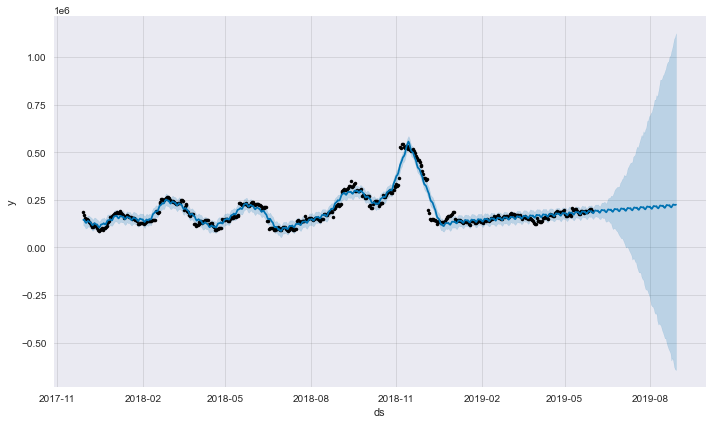

In [51]:
fig1 = model1.plot(forecast)

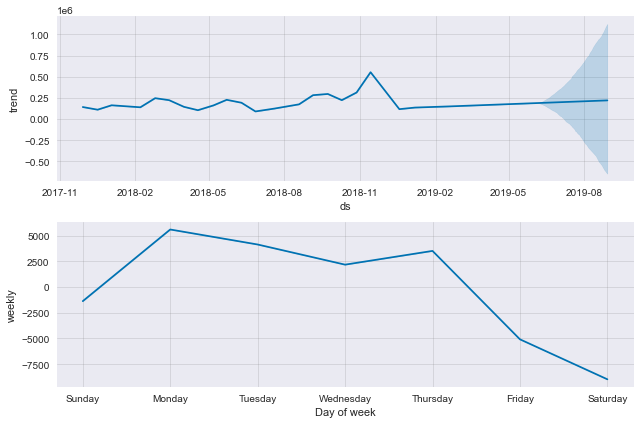

In [52]:
fig2 = model1.plot_components(forecast)

In [54]:
metric_df = forecast.set_index('ds')[['yhat']].join(df_pro.set_index('ds').y).reset_index()

In [55]:
# y values not populated here because it's forecasting at this point
metric_df.tail()

,ds,yhat,y
634,2019-08-25,218386.19,NaN
635,2019-08-26,225717.90,NaN
636,2019-08-27,224627.94,NaN
637,2019-08-28,223037.80,NaN
638,2019-08-29,224742.92,NaN


In [57]:
metric_df.head()

,ds,yhat,y
0,2017-11-29,145032.06,183857.22
1,2017-11-30,144627.87,170445.26
2,2017-12-01,134293.99,157155.01
3,2017-12-02,128667.24,147467.73
4,2017-12-03,134524.17,147991.02


In [58]:
metric_df.dropna(inplace=True)

In [59]:
# now only have df with values that have true y values
metric_df.tail()

,ds,yhat,y
544,2019-05-27,192165.40,195395.17
545,2019-05-28,191075.43,200298.34
546,2019-05-29,189485.29,200717.34
547,2019-05-30,191190.41,198456.74
548,2019-05-31,182965.84,191391.68


In [60]:
r2_score(metric_df.y, metric_df.yhat)

0.932007976774746

In [61]:
mean_absolute_error(metric_df.y, metric_df.yhat)

16681.447905282334

In [62]:
mean_squared_error(metric_df.y, metric_df.yhat)

532833842.0072344

So, at this point we have tested 3 models and the consolidated view of the evalation metrics in question are shown below:

From this viewpoint it looks like the Random Forest is the best performing model. This is of course only a training process that was run on everything, not each of the individual countries so performance could change country to country.

### 3. Re-train your model on all of the data using the selected approach and prepare it for deployment. 

The model.py file in my github repo retrains the Random Forest model on all the data prior to saving it

Everything after this is playing around with the cross_validation functionality that the Prohpet model has

In [28]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(model1, initial='500 days', period = '7 days', horizon = '30 days')
df_cv.head()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2019-04-17 00:00:00 and 2019-05-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-04-18,165218.416536,134032.238613,198179.928860,172397.87,2019-04-17
1,2019-04-19,156583.335949,126701.786177,187982.304468,162855.45,2019-04-17
2,2019-04-20,152540.539811,120672.151814,183915.007418,167452.17,2019-04-17
3,2019-04-21,160283.959109,129044.182222,195010.703945,180061.09,2019-04-17
4,2019-04-22,167757.531952,135736.245159,198184.247742,187352.23,2019-04-17


In [29]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
85,2019-05-27,183837.652684,75397.010594,307516.257100,195395.17,2019-05-01
86,2019-05-28,182950.623318,67793.320810,317995.925167,200298.34,2019-05-01
87,2019-05-29,181334.554893,56938.356993,318805.569511,200717.34,2019-05-01
88,2019-05-30,182577.573503,56924.257380,336825.455568,198456.74,2019-05-01
89,2019-05-31,174379.984623,36615.736169,335695.961600,191391.68,2019-05-01


In [30]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,2.227091e+08,14923.440776,11376.382021,0.063293,0.041645,1.0
1,4 days,2.634361e+08,16230.713615,12827.734237,0.071336,0.089050,1.0
2,5 days,2.778059e+08,16667.511504,14190.600427,0.077958,0.089050,1.0
3,6 days,2.977656e+08,17255.885758,14952.030753,0.079886,0.104587,1.0
4,7 days,2.734881e+08,16537.474756,14262.495784,0.076390,0.087255,1.0


In [31]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
23,26 days,5.752039e+08,23983.408329,22021.886058,0.113310,0.097438,1.0
24,27 days,4.477135e+08,21159.241527,19324.190378,0.098367,0.086609,1.0
25,28 days,3.142724e+08,17727.728554,16266.021669,0.083236,0.085928,1.0
26,29 days,2.407445e+08,15515.942937,14900.834325,0.077339,0.085928,1.0
27,30 days,2.637754e+08,16241.163930,15806.563692,0.083118,0.085928,1.0


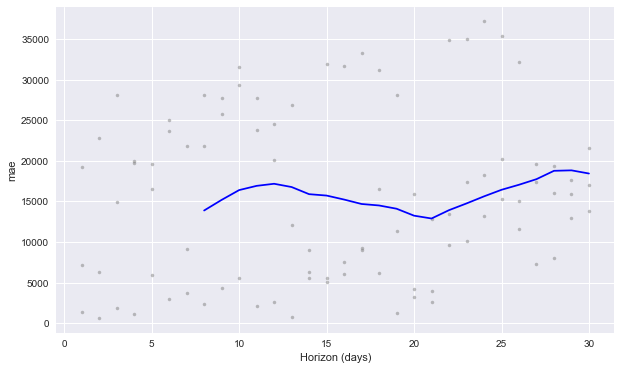

In [32]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mae', rolling_window=0.25)